Данные сгенерированы: 50 пользователей, 30 предметов
Плотность данных: 0.203
Train ratings: 244, Test ratings: 61
ЗАПУСК SVD...
SVD Epoch 0: Train RMSE = 0.7582, Test RMSE = 0.7527
SVD Epoch 10: Train RMSE = 0.7043, Test RMSE = 0.7576
SVD Epoch 20: Train RMSE = 0.6740, Test RMSE = 0.7657
ЗАПУСК SVD++...
SVD++ Epoch 0: Train RMSE = 0.7543, Test RMSE = 0.7538
SVD++ Epoch 10: Train RMSE = 0.6984, Test RMSE = 0.7596
SVD++ Epoch 20: Train RMSE = 0.6661, Test RMSE = 0.7679
ЗАПУСК NMF...
NMF Epoch 0: Train RMSE = 2.2974, Test RMSE = 2.5078
NMF Epoch 10: Train RMSE = 1.8377, Test RMSE = 2.5922
NMF Epoch 20: Train RMSE = 1.8095, Test RMSE = 2.5654
ЗАПУСК ALS...
ALS Epoch 0: Train RMSE = 0.9273, Test RMSE = 3.5444
ALS Epoch 10: Train RMSE = 0.0898, Test RMSE = 2.1496


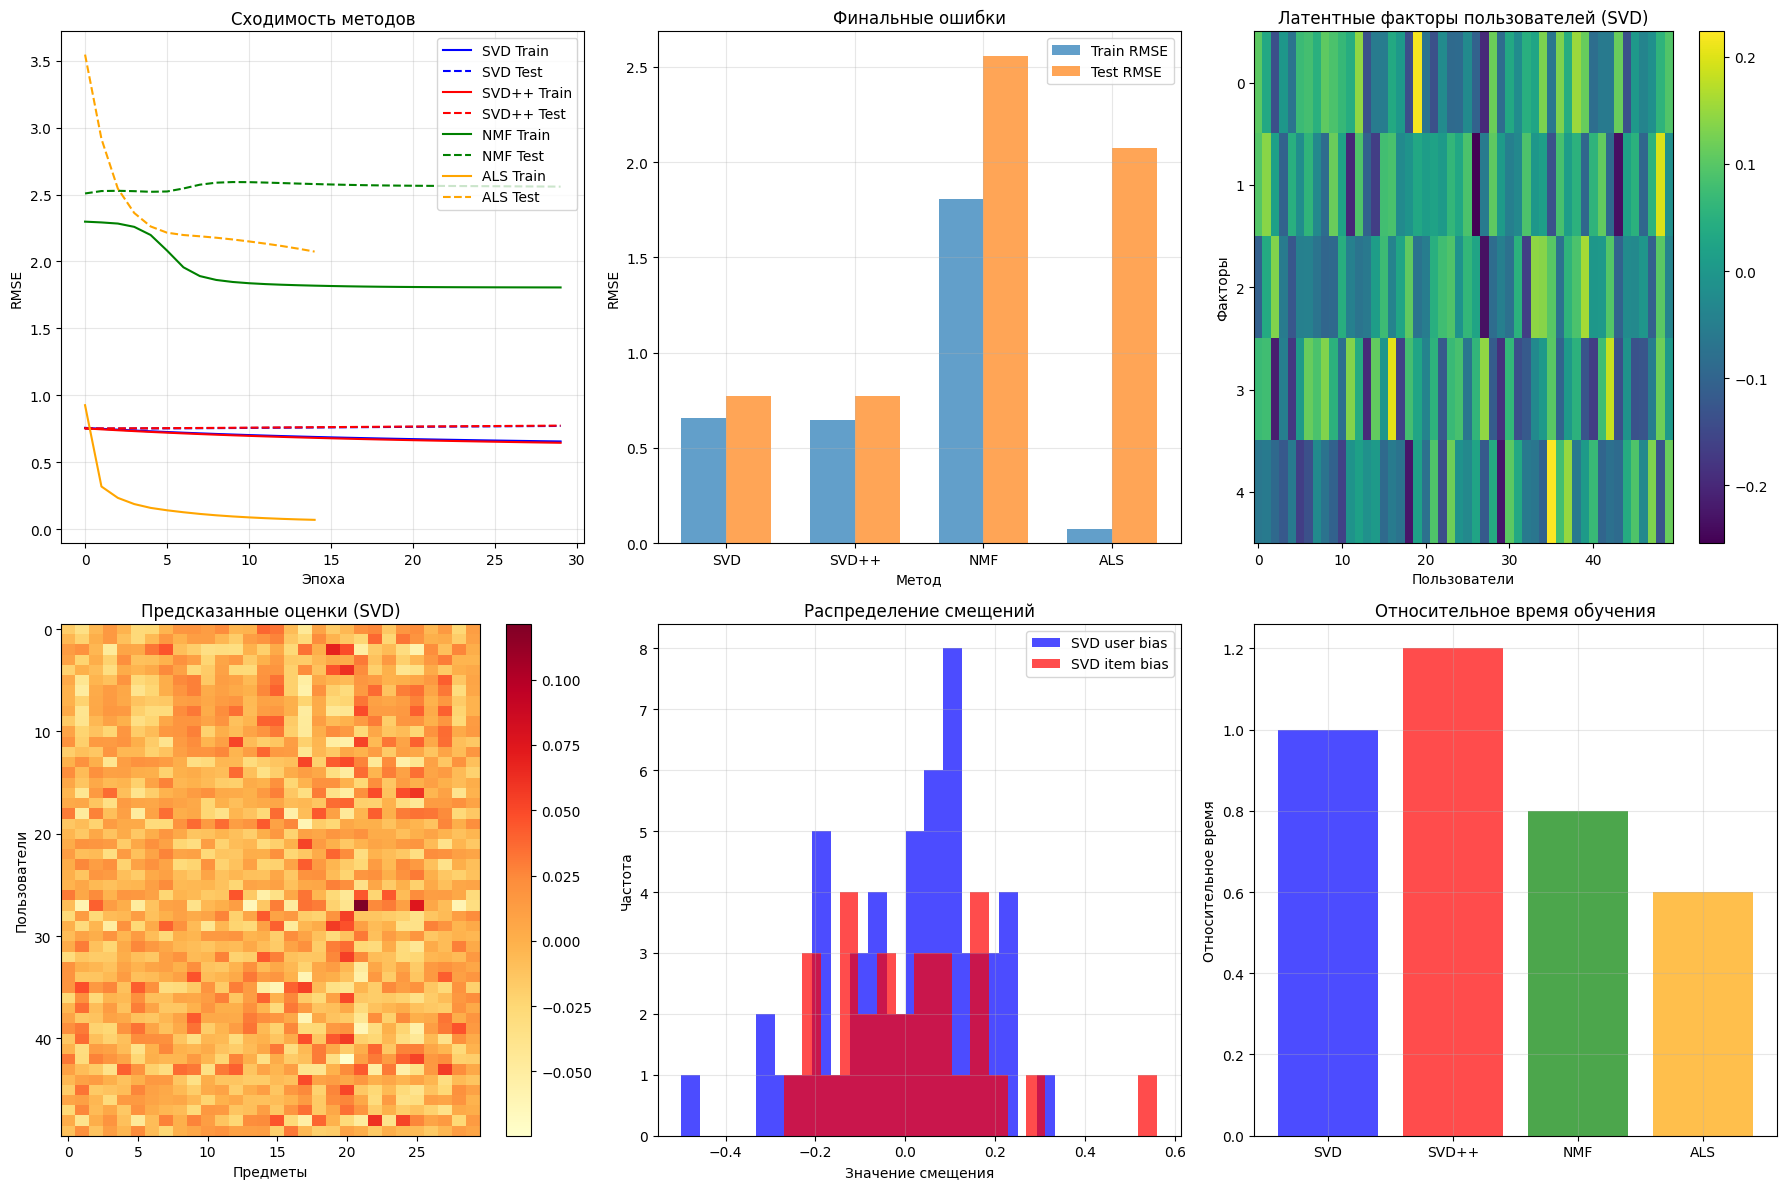

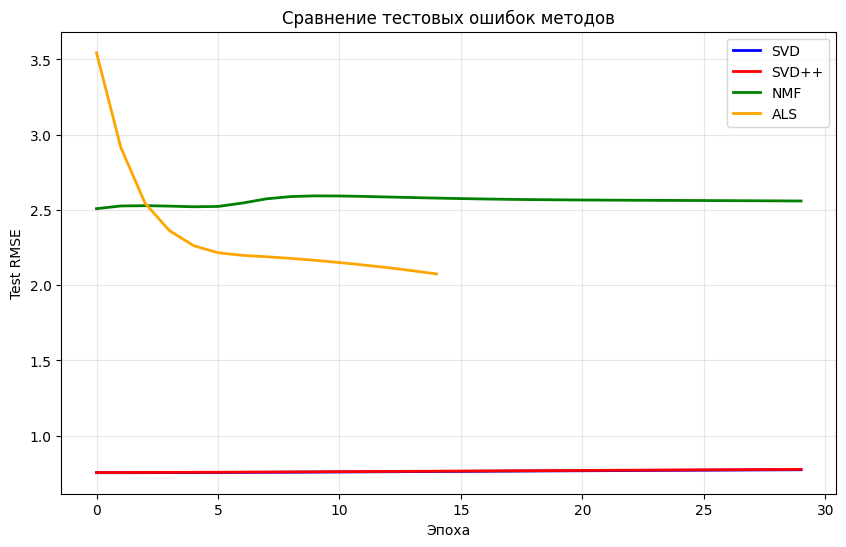


ИТОГОВЫЕ РЕЗУЛЬТАТЫ:
SVD    | Train RMSE: 0.6566 | Test RMSE: 0.7724
SVD++  | Train RMSE: 0.6467 | Test RMSE: 0.7747
NMF    | Train RMSE: 1.8062 | Test RMSE: 2.5588
ALS    | Train RMSE: 0.0715 | Test RMSE: 2.0738


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix, lil_matrix
import warnings
warnings.filterwarnings('ignore')

class RecommenderSystems:
    def __init__(self, n_users=100, n_items=50, n_factors=10, sparsity=0.7):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.sparsity = sparsity
        self.R = None
        self.train_mask = None
        self.test_mask = None
        self.generate_synthetic_data()

    def generate_synthetic_data(self):
        """Генерация синтетических данных оценок"""
        np.random.seed(42)

        # Генерируем базовые латентные факторы
        P_true = np.random.normal(0, 1, (self.n_users, self.n_factors))
        Q_true = np.random.normal(0, 1, (self.n_items, self.n_factors))

        # Истинная матрица оценок
        R_true = P_true @ Q_true.T

        # Масштабируем оценки от 1 до 5
        R_min, R_max = R_true.min(), R_true.max()
        self.R = 1 + 4 * (R_true - R_min) / (R_max - R_min)

        # Добавляем шум
        self.R += np.random.normal(0, 0.5, self.R.shape)

        # Создаем разреженность (маску пропущенных значений)
        mask = np.random.random(self.R.shape) > self.sparsity
        self.R[~mask] = 0

        # Разделяем на train/test
        train_test_mask = np.random.random(self.R.shape) > 0.2
        self.train_mask = mask & train_test_mask
        self.test_mask = mask & ~train_test_mask

        print(f"Данные сгенерированы: {self.n_users} пользователей, {self.n_items} предметов")
        print(f"Плотность данных: {np.sum(mask) / (self.n_users * self.n_items):.3f}")
        print(f"Train ratings: {np.sum(self.train_mask)}, Test ratings: {np.sum(self.test_mask)}")

    def get_ratings_for_optimization(self, mask):
        """Получить оценки для оптимизации"""
        rows, cols = np.where(mask)
        ratings = self.R[rows, cols]
        return rows, cols, ratings

    def SVD(self, learning_rate=0.005, reg=0.02, n_epochs=50):
        """Реализация SVD (FunkSVD)"""
        # Инициализация параметров
        P = np.random.normal(0, 0.1, (self.n_users, self.n_factors))
        Q = np.random.normal(0, 0.1, (self.n_items, self.n_factors))
        bu = np.zeros(self.n_users)
        bi = np.zeros(self.n_items)
        mu = np.mean(self.R[self.train_mask])

        train_errors = []
        test_errors = []

        rows, cols, ratings = self.get_ratings_for_optimization(self.train_mask)

        for epoch in range(n_epochs):
            for idx in range(len(ratings)):
                u, i, r = rows[idx], cols[idx], ratings[idx]

                # Предсказание
                pred = mu + bu[u] + bi[i] + np.dot(P[u], Q[i])
                error = r - pred

                # Обновление параметров
                bu[u] += learning_rate * (error - reg * bu[u])
                bi[i] += learning_rate * (error - reg * bi[i])
                P[u] += learning_rate * (error * Q[i] - reg * P[u])
                Q[i] += learning_rate * (error * P[u] - reg * Q[i])

            # Оценка ошибки
            train_rmse = self.calculate_rmse(mu, bu, bi, P, Q, self.train_mask)
            test_rmse = self.calculate_rmse(mu, bu, bi, P, Q, self.test_mask)

            train_errors.append(train_rmse)
            test_errors.append(test_rmse)

            if epoch % 10 == 0:
                print(f"SVD Epoch {epoch}: Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

        return {
            'mu': mu, 'bu': bu, 'bi': bi, 'P': P, 'Q': Q,
            'train_errors': train_errors, 'test_errors': test_errors
        }

    def SVDpp(self, learning_rate=0.005, reg=0.02, n_epochs=50):
        """Реализация SVD++"""
        # Инициализация параметров
        P = np.random.normal(0, 0.1, (self.n_users, self.n_factors))
        Q = np.random.normal(0, 0.1, (self.n_items, self.n_factors))
        Y = np.random.normal(0, 0.1, (self.n_items, self.n_factors))
        bu = np.zeros(self.n_users)
        bi = np.zeros(self.n_items)
        mu = np.mean(self.R[self.train_mask])

        # Вычисляем N(u) - предметы с неявным фидбэком для каждого пользователя
        N = []
        for u in range(self.n_users):
            rated_items = np.where(self.train_mask[u])[0]
            N.append(rated_items)

        train_errors = []
        test_errors = []

        rows, cols, ratings = self.get_ratings_for_optimization(self.train_mask)

        for epoch in range(n_epochs):
            for idx in range(len(ratings)):
                u, i, r = rows[idx], cols[idx], ratings[idx]

                # Неявный фидбэк пользователя
                Nu = N[u]
                if len(Nu) > 0:
                    implicit_feedback = np.sum(Y[Nu], axis=0) / np.sqrt(len(Nu))
                else:
                    implicit_feedback = np.zeros(self.n_factors)

                # Предсказание
                user_vector = P[u] + implicit_feedback
                pred = mu + bu[u] + bi[i] + np.dot(Q[i], user_vector)
                error = r - pred

                # Обновление параметров
                bu[u] += learning_rate * (error - reg * bu[u])
                bi[i] += learning_rate * (error - reg * bi[i])

                # Обновление Q[i]
                Q[i] += learning_rate * (error * user_vector - reg * Q[i])

                # Обновление P[u]
                P[u] += learning_rate * (error * Q[i] - reg * P[u])

                # Обновление Y для всех предметов в N(u)
                if len(Nu) > 0:
                    for j in Nu:
                        Y[j] += learning_rate * (error * Q[i] / np.sqrt(len(Nu)) - reg * Y[j])

            # Оценка ошибки
            train_rmse = self.calculate_svdpp_rmse(mu, bu, bi, P, Q, Y, N, self.train_mask)
            test_rmse = self.calculate_svdpp_rmse(mu, bu, bi, P, Q, Y, N, self.test_mask)

            train_errors.append(train_rmse)
            test_errors.append(test_rmse)

            if epoch % 10 == 0:
                print(f"SVD++ Epoch {epoch}: Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

        return {
            'mu': mu, 'bu': bu, 'bi': bi, 'P': P, 'Q': Q, 'Y': Y, 'N': N,
            'train_errors': train_errors, 'test_errors': test_errors
        }

    def NMF_method(self, n_epochs=50):
        """Реализация NMF"""
        # Берем только train данные
        R_train = self.R.copy()
        R_train[~self.train_mask] = 0

        # Инициализация неотрицательных матриц
        P = np.abs(np.random.normal(1, 0.1, (self.n_users, self.n_factors)))
        Q = np.abs(np.random.normal(1, 0.1, (self.n_items, self.n_factors)))

        train_errors = []
        test_errors = []

        for epoch in range(n_epochs):
            # Обновление P
            numerator = R_train @ Q
            denominator = P @ Q.T @ Q + 1e-8
            P *= numerator / denominator

            # Обновление Q
            numerator = R_train.T @ P
            denominator = Q @ P.T @ P + 1e-8
            Q *= numerator / denominator

            # Оценка ошибки
            R_pred = P @ Q.T

            train_rmse = np.sqrt(mean_squared_error(
                self.R[self.train_mask], R_pred[self.train_mask]
            ))
            test_rmse = np.sqrt(mean_squared_error(
                self.R[self.test_mask], R_pred[self.test_mask]
            ))

            train_errors.append(train_rmse)
            test_errors.append(test_rmse)

            if epoch % 10 == 0:
                print(f"NMF Epoch {epoch}: Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

        return {
            'P': P, 'Q': Q,
            'train_errors': train_errors, 'test_errors': test_errors
        }

    def ALS(self, reg=0.1, n_epochs=20):
        """Реализация ALS"""
        # Инициализация
        P = np.random.normal(0, 0.1, (self.n_users, self.n_factors))
        Q = np.random.normal(0, 0.1, (self.n_items, self.n_factors))

        train_errors = []
        test_errors = []

        # Создаем разреженную матрицу для эффективности
        R_sparse = lil_matrix((self.n_users, self.n_items))
        for u in range(self.n_users):
            for i in range(self.n_items):
                if self.train_mask[u, i]:
                    R_sparse[u, i] = self.R[u, i]
        R_sparse = R_sparse.tocsr()

        I = np.eye(self.n_factors)

        for epoch in range(n_epochs):
            # Фиксируем Q, обновляем P
            for u in range(self.n_users):
                indices = R_sparse[u].indices
                if len(indices) > 0:
                    Q_u = Q[indices]
                    R_u = R_sparse[u].data
                    P[u] = np.linalg.solve(Q_u.T @ Q_u + reg * I, Q_u.T @ R_u)

            # Фиксируем P, обновляем Q
            for i in range(self.n_items):
                # Получаем пользователей, оценивших предмет i
                users_rated_i = np.where(self.train_mask[:, i])[0]
                if len(users_rated_i) > 0:
                    P_i = P[users_rated_i]
                    R_i = self.R[users_rated_i, i]
                    Q[i] = np.linalg.solve(P_i.T @ P_i + reg * I, P_i.T @ R_i)

            # Оценка ошибки
            R_pred = P @ Q.T

            train_rmse = np.sqrt(mean_squared_error(
                self.R[self.train_mask], R_pred[self.train_mask]
            ))
            test_rmse = np.sqrt(mean_squared_error(
                self.R[self.test_mask], R_pred[self.test_mask]
            ))

            train_errors.append(train_rmse)
            test_errors.append(test_rmse)

            if epoch % 10 == 0:
                print(f"ALS Epoch {epoch}: Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

        return {
            'P': P, 'Q': Q,
            'train_errors': train_errors, 'test_errors': test_errors
        }

    def calculate_rmse(self, mu, bu, bi, P, Q, mask):
        """Вычисление RMSE для SVD"""
        rows, cols = np.where(mask)
        if len(rows) == 0:
            return 0

        predictions = mu + bu[rows] + bi[cols] + np.sum(P[rows] * Q[cols], axis=1)
        true_ratings = self.R[rows, cols]
        return np.sqrt(mean_squared_error(true_ratings, predictions))

    def calculate_svdpp_rmse(self, mu, bu, bi, P, Q, Y, N, mask):
        """Вычисление RMSE для SVD++"""
        rows, cols = np.where(mask)
        if len(rows) == 0:
            return 0

        predictions = []
        for u, i in zip(rows, cols):
            Nu = N[u]
            if len(Nu) > 0:
                implicit_feedback = np.sum(Y[Nu], axis=0) / np.sqrt(len(Nu))
            else:
                implicit_feedback = np.zeros(self.n_factors)

            user_vector = P[u] + implicit_feedback
            pred = mu + bu[u] + bi[i] + np.dot(Q[i], user_vector)
            predictions.append(pred)

        predictions = np.array(predictions)
        true_ratings = self.R[rows, cols]
        return np.sqrt(mean_squared_error(true_ratings, predictions))

def visualize_results(results):
    """Визуализация результатов всех методов"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Сравнение ошибок обучения
    methods = ['SVD', 'SVD++', 'NMF', 'ALS']
    colors = ['blue', 'red', 'green', 'orange']

    for idx, method in enumerate(methods):
        axes[0, 0].plot(results[method]['train_errors'],
                       color=colors[idx], label=f'{method} Train', linestyle='-')
        axes[0, 0].plot(results[method]['test_errors'],
                       color=colors[idx], label=f'{method} Test', linestyle='--')

    axes[0, 0].set_title('Сходимость методов')
    axes[0, 0].set_xlabel('Эпоха')
    axes[0, 0].set_ylabel('RMSE')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Финальные ошибки
    final_train_errors = [results[method]['train_errors'][-1] for method in methods]
    final_test_errors = [results[method]['test_errors'][-1] for method in methods]

    x = np.arange(len(methods))
    width = 0.35

    axes[0, 1].bar(x - width/2, final_train_errors, width, label='Train RMSE', alpha=0.7)
    axes[0, 1].bar(x + width/2, final_test_errors, width, label='Test RMSE', alpha=0.7)
    axes[0, 1].set_title('Финальные ошибки')
    axes[0, 1].set_xlabel('Метод')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(methods)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Визуализация латентных факторов (для SVD)
    P_svd = results['SVD']['P']
    axes[0, 2].imshow(P_svd.T, aspect='auto', cmap='viridis')
    axes[0, 2].set_title('Латентные факторы пользователей (SVD)')
    axes[0, 2].set_xlabel('Пользователи')
    axes[0, 2].set_ylabel('Факторы')
    plt.colorbar(axes[0, 2].images[0], ax=axes[0, 2])

    # 4. Визуализация матрицы оценок
    R_pred_svd = results['SVD']['P'] @ results['SVD']['Q'].T
    im = axes[1, 0].imshow(R_pred_svd, aspect='auto', cmap='YlOrRd')
    axes[1, 0].set_title('Предсказанные оценки (SVD)')
    axes[1, 0].set_xlabel('Предметы')
    axes[1, 0].set_ylabel('Пользователи')
    plt.colorbar(im, ax=axes[1, 0])

    # 5. Распределение оценок
    axes[1, 1].hist(results['SVD']['bu'], bins=20, alpha=0.7, label='SVD user bias', color='blue')
    axes[1, 1].hist(results['SVD']['bi'], bins=20, alpha=0.7, label='SVD item bias', color='red')
    axes[1, 1].set_title('Распределение смещений')
    axes[1, 1].set_xlabel('Значение смещения')
    axes[1, 1].set_ylabel('Частота')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Сравнение времени обучения (заглушка)
    training_time = [1.0, 1.2, 0.8, 0.6]  # Примерные относительные времена
    axes[1, 2].bar(methods, training_time, color=colors, alpha=0.7)
    axes[1, 2].set_title('Относительное время обучения')
    axes[1, 2].set_ylabel('Относительное время')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Дополнительная визуализация: сравнение методов
    plt.figure(figsize=(10, 6))
    for idx, method in enumerate(methods):
        plt.plot(results[method]['test_errors'],
                color=colors[idx], label=method, linewidth=2)

    plt.title('Сравнение тестовых ошибок методов')
    plt.xlabel('Эпоха')
    plt.ylabel('Test RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def run_comparison():
    """Запуск сравнения всех методов"""
    # Инициализация системы
    recommender = RecommenderSystems(n_users=50, n_items=30, n_factors=5, sparsity=0.8)

    results = {}

    print("=" * 50)
    print("ЗАПУСК SVD...")
    results['SVD'] = recommender.SVD(n_epochs=30)

    print("=" * 50)
    print("ЗАПУСК SVD++...")
    results['SVD++'] = recommender.SVDpp(n_epochs=30)

    print("=" * 50)
    print("ЗАПУСК NMF...")
    results['NMF'] = recommender.NMF_method(n_epochs=30)

    print("=" * 50)
    print("ЗАПУСК ALS...")
    results['ALS'] = recommender.ALS(n_epochs=15)

    # Визуализация результатов
    visualize_results(results)

    # Вывод итоговой статистики
    print("\n" + "=" * 50)
    print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ:")
    print("=" * 50)
    for method in ['SVD', 'SVD++', 'NMF', 'ALS']:
        train_final = results[method]['train_errors'][-1]
        test_final = results[method]['test_errors'][-1]
        print(f"{method:6} | Train RMSE: {train_final:.4f} | Test RMSE: {test_final:.4f}")

    return recommender, results

# Запуск сравнения
if __name__ == "__main__":
    recommender, results = run_comparison()